# Fetal Health Classification

**Overview**

Here we'll attempt to create machine learning models able to classify different fetal Cardiotocograms (CTGs) into one of three different classes: Normal, Suspect, or Pathological. 

The researchers who created this dataset did a very thorough job preprocessing and generating useful statistics with their data, and this is an excellent dataset to test the performance of different machine learning models using numerical features. 

In [1]:
import pandas as pd

#Read the dataset into a DataFrame
fetal_data = pd.read_csv('../Data/fetal_health.csv')


In [2]:
#We'll check to make sure the data loaded properly
fetal_data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [3]:
#Let's look and see if there are any missing values within this dataset
fetal_data.isnull().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

Beautiful - the researchers did an incredibly thorough job collecting and prepocessing their data. 

Note that at this stage, we would usually determine a strategy for dealing with missing values in our dataset, as well as mapping any categorical features to numerical values as appropriate. Addtionally, if our prepocessing was intensive, it would be good practice to define a pipeline to standardize this for us. 

In [4]:
#First we'll extract the features we want to use for prediction in our dataset
X = fetal_data.drop('fetal_health', axis=1)

#We'll take a high level statistical overview of these biological features
X.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000


In [5]:
#Next, we'll extract our classification target
y = fetal_data['fetal_health']

#Let's look at the frequency of each class in this dataset
y.value_counts()

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

Text(0, 0.5, 'Frequency')

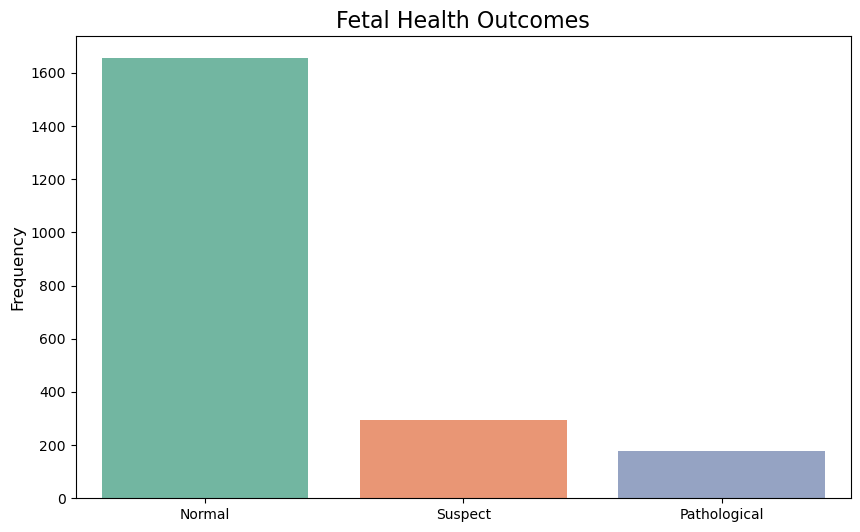

In [6]:
#Let's visualize our class
from matplotlib import pyplot as plt
import seaborn as sns

classes = ['Normal', 'Suspect', 'Pathological']
plt.figure(figsize=(10, 6))
plt.title('Fetal Health Outcomes', fontsize=16)
sns.barplot(x=classes, y=y.value_counts(), palette='Set2')
plt.ylabel('Frequency', fontsize=12)


It looks like in this dataset 1655 birth events were categorized as Normal, 295 as Suspect, and 176 as pathological by the expert obstetricians who collaborated with the research.

**Note that the researchers decided to use ordinal encoding for mapping their class variable to float values.**

In [7]:
#Now we'll split our data into training and test sets for validating our models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                    test_size=0.2, random_state=0)

# **Here we'll define and test 3 separate machine learning algorithms for making classifications with this dataset.**

The algorithms we'll use on this dataset are:
1. RandomForestClassifier
2. KNeighborsClassifer
3. SVC

In [8]:
#Model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Validation
from sklearn.metrics import mean_absolute_error


**1) RandomForestClassifier**. 

The reason in starting here is that it's well established that both decision trees and random forests perform well when making classifications on clinical observations, particularly in this case where our data has been annotated by medical experts. Here we're primarily interested in modeling these experts' clinical decision making. 

The parameter we'll optimize is n_estimators. 

In [9]:
#Define some RandomForestClassifier models
forest_model_1 = RandomForestClassifier(n_estimators=10, random_state=0)
forest_model_2 = RandomForestClassifier(n_estimators=50, random_state=0)
forest_model_3 = RandomForestClassifier(n_estimators=100, random_state=0)
forest_model_4 = RandomForestClassifier(n_estimators=150, random_state=0)
forest_model_5 = RandomForestClassifier(n_estimators=200, random_state=0)

forest_models = [forest_model_1, forest_model_2, forest_model_3, 
                 forest_model_4, forest_model_5]

#Create a function that will score each model using mean_absolute_error
def score_model(model, X_t=X_train, X_v=X_test, y_t=y_train, y_v=y_test):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

#Iterate through each model and measure its performance based on our n_estimators
#parameter
for i in range(0, len(forest_models)):
    mae = score_model(forest_models[i])
    print(f'The MAE for Forest_Model_{i+1} is: {mae}')
    

The MAE for Forest_Model_1 is: 0.08685446009389672
The MAE for Forest_Model_2 is: 0.07981220657276995
The MAE for Forest_Model_3 is: 0.06572769953051644
The MAE for Forest_Model_4 is: 0.07042253521126761
The MAE for Forest_Model_5 is: 0.06807511737089202


It's clear that n_estimators = 100 is the best parameter value for our RandomForestClassifier, which is the default value for this model! Note also that this MAE is quite good so far.

**2) KNeighborsClassifer.**

The first thing we'll determine is whether to use weighted KNN or not, as this does sometimes vary in performance from dataset to dataset. Note that we're holding n_neighbors constant here.


In [10]:
#Define a normal and a weighted KNN model
normal_model = KNeighborsClassifier(weights='uniform')
weighted_model = KNeighborsClassifier(weights='distance')

isoform_test = [normal_model, weighted_model]

#Test which KNeighborsClassifer isoform performs better
for i in range(0, len(isoform_test)):
    isoform_mae = score_model(isoform_test[i])
    print(f'The MAE for Knn_Model_{isoform_test[i].weights} is: {isoform_mae}')

The MAE for Knn_Model_uniform is: 0.13615023474178403
The MAE for Knn_Model_distance is: 0.12441314553990611


It's clear that weighted k nearest neighbors performs better here, so we'll use it moving forward.

In [11]:
#We'll define some different weighted KNeighborsClassifer models
knn_model_1 = KNeighborsClassifier(n_neighbors=2, weights='distance')
knn_model_2 = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn_model_3 = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model_4 = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn_model_5 = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_model_6 = KNeighborsClassifier(n_neighbors=20, weights='distance')

knn_models = [knn_model_1, knn_model_2, knn_model_3, knn_model_4, knn_model_5, knn_model_6]

#Now we'll score each model using mean_absolute_error
for i in range(0, len(knn_models)):
    knn_mae = score_model(knn_models[i])
    print(f'The MAE for Knn_Model_{i+1} is: {knn_mae}')

The MAE for Knn_Model_1 is: 0.11502347417840375
The MAE for Knn_Model_2 is: 0.11971830985915492
The MAE for Knn_Model_3 is: 0.12441314553990611
The MAE for Knn_Model_4 is: 0.1267605633802817
The MAE for Knn_Model_5 is: 0.13615023474178403
The MAE for Knn_Model_6 is: 0.13145539906103287


Our KNeighborsClassifier model performs best with n_neighbors = 2. Interestingly enough, it looks like our MAE starts to look non monotonic at k_neighbors = 20. This however is an extreme number of neighbors. 

For scalability reasons applying this model to classify new observations outside of our dataset, I don't think it's a good idea to go below n_neighbors = 2, so we'll take this as our best KNeighborsClassifier model.  

**3) SVC (Support Vector Classifier)**

Here we'll use three different kernels: rbf, sigmoid, and poly, and determine which performs best with our dataset. 

In [12]:
#Define some SVC models
svc_model_1 = SVC(kernel='rbf')
svc_model_2 = SVC(kernel='sigmoid')
svc_model_3 = SVC(kernel='poly')

svc_models = [svc_model_1, svc_model_2, svc_model_3]

#And we'll test each of these SVCs
for i in range(0, len(svc_models)):
    svc_mae = score_model(svc_models[i])
    print(f'The MAE for SVC_Model_{i+1} is: {svc_mae}')


The MAE for SVC_Model_1 is: 0.18309859154929578
The MAE for SVC_Model_2 is: 0.3685446009389671
The MAE for SVC_Model_3 is: 0.17370892018779344


It's clear here that the poly kernel performs best out of our three SVC models, while the sigmoid kernel has by far the worst performance from any model we've applied. 

In [13]:
best_models = [forest_model_3, knn_model_3, svc_model_3]

#We'll train each of our selected models on our full dataset
for model in best_models:
    model.fit(X, y)

#Display each model along with its MAE
maes = []
for i in range(0, len(best_models)):
    mae = score_model(best_models[i])
    maes.append(mae)
    print(f'The MAE for our final {best_models[i]}_Model is: {mae}')


The MAE for our final RandomForestClassifier(random_state=0)_Model is: 0.06572769953051644
The MAE for our final KNeighborsClassifier(weights='distance')_Model is: 0.12441314553990611
The MAE for our final SVC(kernel='poly')_Model is: 0.17370892018779344


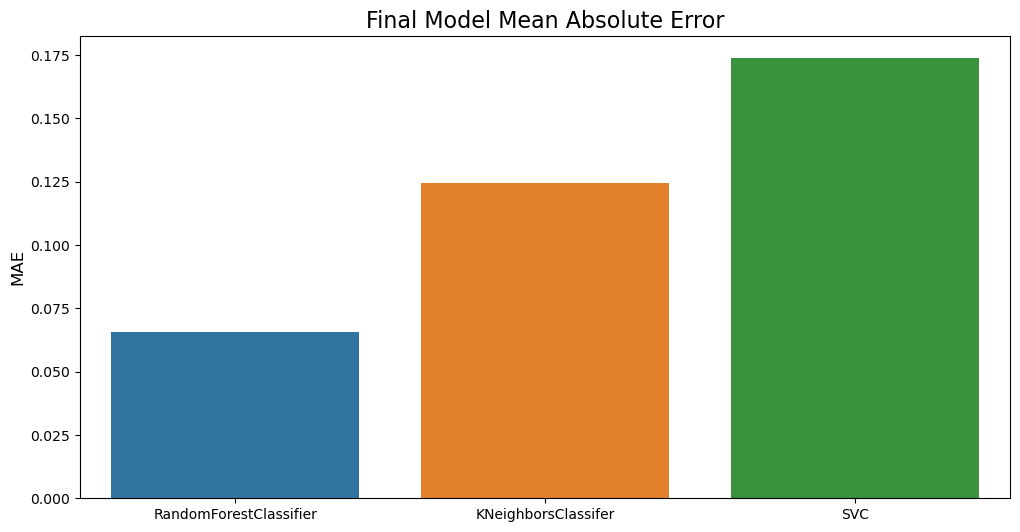

In [14]:
#Lets visualize these results
plt.figure(figsize=(12,6))
plt.title('Final Model Mean Absolute Error', fontsize=16)
plt.ylabel('MAE', fontsize=12)
ax = sns.barplot(x=['RandomForestClassifier', 'KNeighborsClassifer', 'SVC'], 
                 y=maes)


# **Conclusions:**

**The RandomForestClassifier performed the best on this dataset by far.**

Using the information we empirically found in this analysis, along with the model that we've already trained, we can further develop tools that could be used to identify at risk fetuses during a birth event in real time. 

One incredibly useful property of random forests is that they push the most influential variables to the top of the tree. We could look for variables the random forest identified as having strong predictive power in classifying outcomes and specifically monitor adverse changes in those variables that might predict pathology in birth. A clinician could use this information to mobilize preventative measures before a full decomposition of patient health is actually reached.

In [15]:
"""We now have 3 fully trained models that we can use to make classifications on
fetal cardiotocogram data!"""
final_forest_model, final_knn_model, final_svc_model = best_models